In [28]:
# Import libraries
import math
import time 
import numpy             as      np
import pandas            as      pd
import matplotlib.pyplot as      plt 
import tensorflow        as      tf
from   tensorflow        import  keras
from   df_simplex        import  df_simplex
from   ord               import  ord

In [29]:
# Set seed
np.random.seed(2022)

# Download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

# Model/data parameters
num_classes = 10
input_shape = (784,)

# Convert images to float
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Reshape each image
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((10000, 784))

# One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [30]:
# Define the DNN architecture
model = keras.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(tf.keras.layers.Reshape((28,28,1), input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation("softmax"))

# Load pre-weights
model.load_weights("./mnist_model.h5")

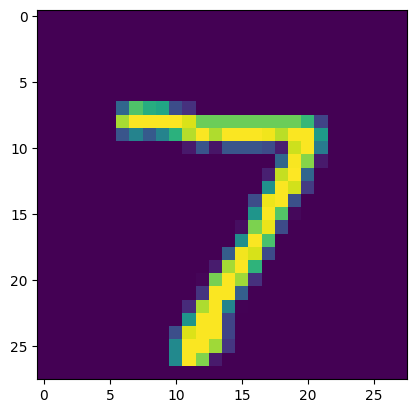

In [31]:
# Select an image to attack
x_attacked = x_test[0]
y_true_attacked = y_test[0]

plt.imshow(x_attacked.reshape((28,28,1)))

In [32]:
n = int(np.prod(input_shape)) # dimension
n_atoms = int(2*n) # n_atoms
tau = 5e-1*n
x_attacked_rewritten = np.arctanh(2e0*((np.double(x_attacked)+1)/257)-1e0)
A = tau * np.hstack([np.eye(n), -np.eye(n)]) + np.expand_dims(x_attacked_rewritten,axis=1)
i0 = np.random.randint(n_atoms)

In [33]:
def obj(x):

    x_obj_rewritten = np.array(x)
    x_obj = np.array(((1e0 + np.tanh(x_obj_rewritten))/2e0)*257-1e0, dtype=np.uint8)

    # Change dimension of x
    x_obj = x_obj.reshape((1,n))

    log_f_x = np.squeeze(np.log(model(x_obj)))
    log_f_x_t0 = log_f_x[np.argmax(y_true_attacked)]
    log_f_x_i = np.partition(log_f_x, -2)[-2]
    
    return float(max(log_f_x_t0 - log_f_x_i, -0))

In [34]:
# call ORD
#--------------------------------------------------------------------------
start = time.time()
x_ord, f_ord, ord_info  = ord(obj, A, i0)
end = time.time()

print("\n")
print("CPU Time:", end-start)

ORD starts:
------------------------------------------------------------------------------------
                                                |     local minimization details    
  it         f         n_f   |A^k|     mu^k     |   n_it     n_f       eps     flag
------------------------------------------------------------------------------------
   0    1.2268e+01      1     1568               |
DF-SIMPLEX starts:
it =  0 , f =  1.2268e+01
it =  1 , f =  1.1366e+01 , n_f =  11 , alpha_max =  5.5437e+02
it =  2 , f =  9.6879e+00 , n_f =  30 , alpha_max =  3.9200e+02
it =  3 , f =  8.5966e+00 , n_f =  59 , alpha_max =  1.9600e+02
it =  4 , f =  7.2054e+00 , n_f =  79 , alpha_max =  9.8000e+01
it =  5 , f =  6.2951e+00 , n_f =  99 , alpha_max =  9.8000e+01
it =  6 , f =  0.0000e+00 , n_f =  400 , alpha_max =  9.8000e+01
target objective value obtained
   1    0.0000e+00   401      1568       0.0000  |     06       400     0.0000      3
target objective value obtained


CPU Time: 2.1380

Text(0.5, 1.0, 'Adv. Example: 3')

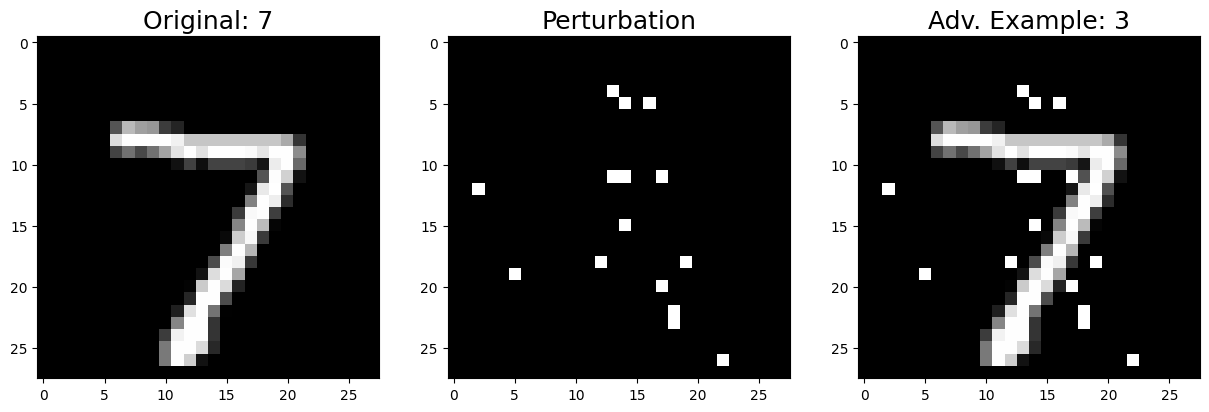

In [35]:
# Define a function to remap the image to the original space
def img_after_ord(x):
    return np.array(((1e0 + np.tanh(x))/2e0)*257-1e0, dtype=np.uint8)

# Make prediction 
img = x_attacked.reshape((28,28,1))/255
noise = (img_after_ord(x_ord) - x_attacked).reshape((28,28,1))
noise = np.clip(noise, 0, 255)
img_adv = img_after_ord(x_ord).reshape((28,28,1))/255
pred = model.predict(x_attacked.reshape((1,784)), verbose=0)
pred_adv = model.predict(img_after_ord(x_ord).reshape((1,784)), verbose=0)

# Plot the figures
fig, axis = plt.subplots(1,3,figsize=(15,5))
axis[0].imshow(img, cmap="gray")
axis[0].set_title("Original: " + str(pred.argmax()), fontsize=18)
axis[1].imshow(noise, cmap="gray")
axis[1].set_title("Perturbation", color="black", fontsize=18)
axis[2].imshow(img_adv, cmap="gray")
axis[2].set_title("Adv. Example: " + str(pred_adv.argmax()), fontsize=18)